# ML Experiment 5c: Hierarchical Clustering
**Aim : Implement Hierarchical Clustering algorithm to categorize data**

In [1]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
plt.style.use('ggplot')

In [2]:
X,y = make_classification(100, n_features=2, n_redundant=0)

# Hierarchical Clustering Implementation
I have tried to comment as much as I could, if you still need clarification, comment please. This implementation is not efficient at all. This is what I call "Visible Implementation". I should be able to know what a code does just by looking at it and reading comments (not documentation) if it is a visible implementation.

In [3]:
class HC:
    def __init__(self, verbose=False, linkage_type='complete'):
        self.verbose = verbose
        self.linkage_type = linkage_type

    def argmin(self, D):
        """
        Given a 2D array, returns the minimum value that is not in the main diagonal, i.e where x = y
        and (x,y) index of that value.
        """
        minx, miny = (0,0)
        min_val = 10e5
        for i in range(D.shape[0]):
            for j in range(D.shape[0]):
                if j==i:
                    continue
                else:
                    if D[i,j] < min_val:
                        min_val = D[i,j]
                        minx = i
                        miny = j

        return min_val, minx, miny

    def cluster_distance(self, cluster_members):
        """
        Calculates the cluster euclidean distances.

        Params
        ------
        cluster_members: dict.
            stores the cluster members in format: {key: [item1, item2 ..]}.
            if key is less than X.shape[0] then, it only has itself in the cluster.

        Returns
        -------
        Distance: 2D array.
            Contains distances between each cluster.
        """
        nClusters = len(cluster_members)
        keys = list(cluster_members.keys())
        Distance = np.zeros((nClusters, nClusters))
        # iterate over all the clusters
        for i in range(nClusters):
            # pick the members of ith cluster
            ith_elems = cluster_members[keys[i]]

            # compare with the other clusters
            for j in range(nClusters):
                # pick the other cluster's members
                jth_elems = cluster_members[keys[j]]
                d_in_clusters = euclidean_distances(X[ith_elems], X[jth_elems])
                if self.linkage_type == 'complete':
                    dij = np.max(d_in_clusters)
                elif self.linkage_type == 'single':
                    dij = np.min(d_in_clusters)
                Distance[i,j] = dij

        # so Distance has minimum distance between clusters
        # row and col of Distance denotes element in `keys`
        return Distance

    def fit(self, X):
        """
        Generates the dendrogram.

        Params
        ------
        X: Dataset, shape (nSamples, nFeatures)

        Returns
        -------
        Z: 2D array. shape (nSamples-1, 4).
            Linkage matrix. Stores the merge information at each iteration.
        """
        self.nSamples = X.shape[0]

        cluster_members = {i: [i,] for i in range(self.nSamples)}
        Z = np.zeros((self.nSamples-1,4)) # c1, c2, d, count

        for i in range(self.nSamples-1):
            if self.verbose:
                print(f'\n-------\nDebug Line at, i={i}\n--------')

            nClusters = len(cluster_members)
            keys = list(cluster_members.keys())
            # caculate the distance between existing clusters
            D = self.cluster_distance(cluster_members)
            _, tmpx, tmpy = self.argmin(D)

            if self.verbose:
                print(f'Z:\n{Z}, \nCluster Members: {cluster_members}, D: \n {D}')

            x = keys[tmpx]
            y = keys[tmpy]
            # update Z
            Z[i,0] = x
            Z[i,1] = y
            Z[i,2] = D[tmpx, tmpy] # that's where the min value is
            Z[i,3] = len(cluster_members[x]) + len(cluster_members[y])

            # merge the clusters found
            cluster_members[i+ self.nSamples] = cluster_members[x] + cluster_members[y]
            # remove merged from clusters pool, else they'll be recalculated
            del cluster_members[x]
            del cluster_members[y]

        self.Z = Z
        return self.Z

    def predict(self, n_cluster=3):
        """
        Get cluster label for specific cluster size.

        Params
        ------
        n_cluster: int.
            Number of clusters to keep. Can not be > nSamples

        Returns
        -------
        labels: list.
            Cluster labels for each sample.
        """
        labels = np.zeros((self.nSamples))
        cluster_members = dict([(i,[i]) for i in range(self.nSamples)])
        for i in range(self.nSamples - n_cluster):
            x,y = (Z[i,0], Z[i,1])
            cluster_members[self.nSamples + i] = cluster_members[x] + cluster_members[y]
            del cluster_members[x]
            del cluster_members[y]

        keys = list(cluster_members.keys())

        for i in range(len(keys)):
            samples_in_cluster = cluster_members[keys[i]]
            labels[samples_in_cluster] = i

        return labels

In [4]:
%%time
hc = HC(linkage_type='complete')
Z = hc.fit(X)
myLabel = hc.predict(n_cluster=3)

CPU times: user 23.6 s, sys: 217 ms, total: 23.8 s
Wall time: 23.8 s


sanity check.

In [5]:
%%time
clustering = AgglomerativeClustering(n_clusters=3,linkage='complete').fit(X)
skLabel = clustering.labels_

CPU times: user 1.14 ms, sys: 2.99 ms, total: 4.14 ms
Wall time: 6.01 ms


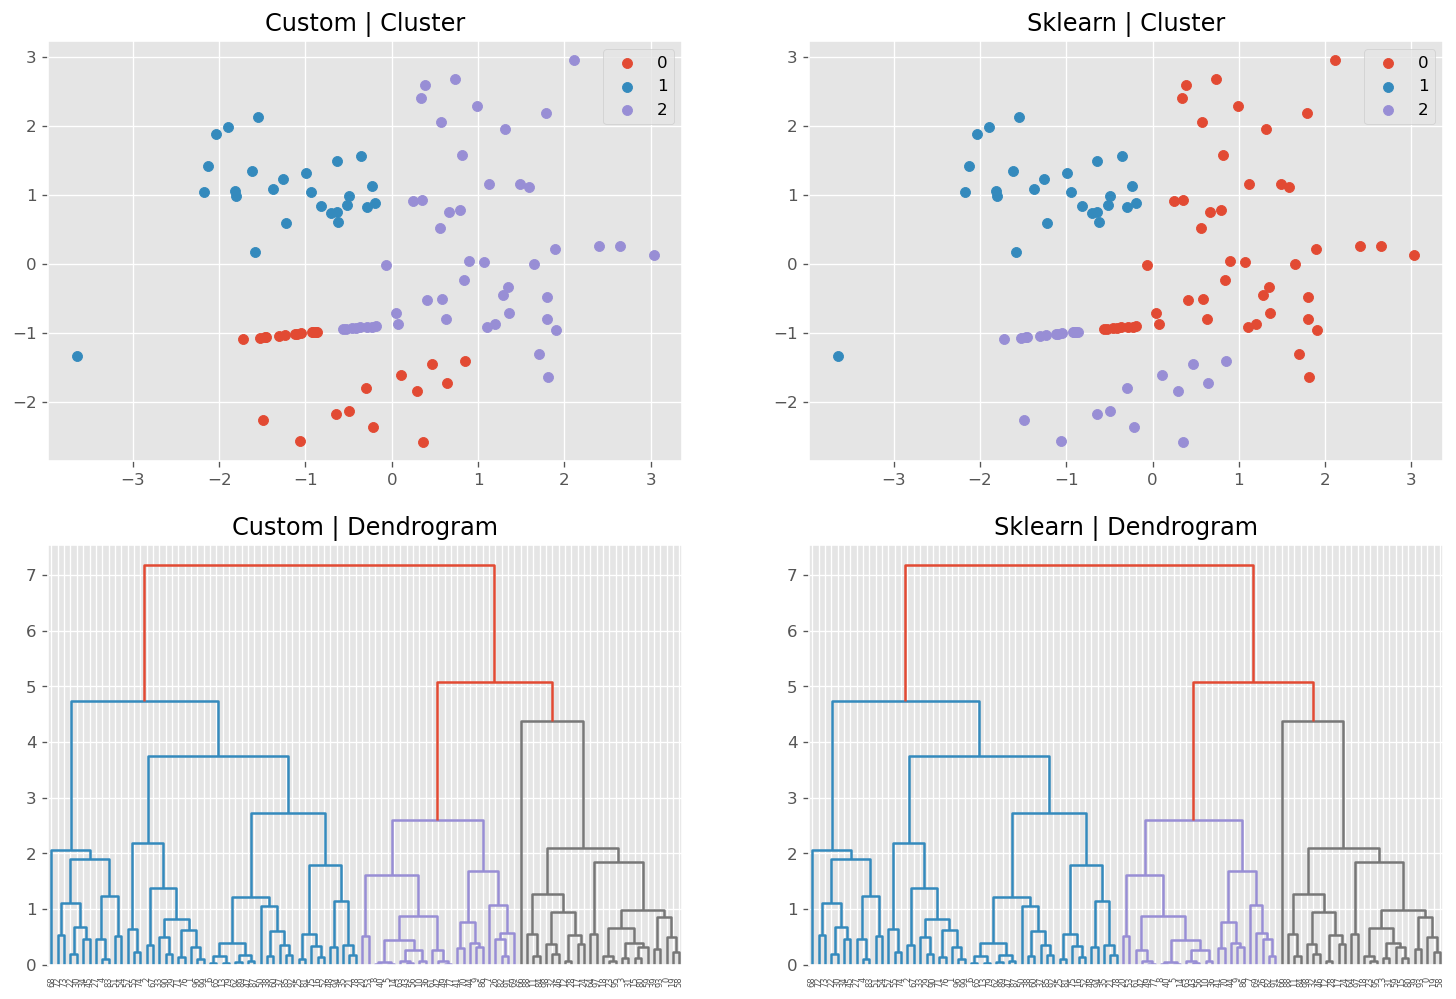

In [6]:
fig, ax = plt.subplots(2,2,facecolor='white',figsize=(15,5*2),dpi=120)

# Cluster
for i in range(3):
    myIndices = myLabel==i
    skIndices = skLabel==i
    ax[0,0].scatter(x=X[myIndices,0], y=X[myIndices,1],label=i)
    ax[0,1].scatter(x=X[skIndices,0], y=X[skIndices,1],label=i)

ax[0,0].set_title('Custom | Cluster')
ax[0,1].set_title('Sklearn | Cluster')
ax[0,0].legend()
ax[0,1].legend()

# Dendrogram
z = hierarchy.linkage(X, 'complete') # scipy agglomerative cluster
hierarchy.dendrogram(Z, ax=ax[1,0]) # plotting mine with their function
hierarchy.dendrogram(z, ax=ax[1,1]) # plotting their with their function

ax[1,0].set_title('Custom | Dendrogram')
ax[1,1].set_title('Sklearn | Dendrogram')
plt.show()